<h1 align="center">Performance Robustness Evaluation for Statistical Classifiers (PRESC) </h1> 

# Train-test splitting

### How to split the dataset in a training and validation sets?

The **optimal ratio** to split the data between the **training and the test data** subsets is **not an obvious issue**. And this becomes even more relevant whith **small or moderate volume** datasets.

Using more data to train the model helps to obtain more accurate models, yielding less variance in the model parameters, but with less data to assess the model, it is the performance's evaluation which ends up having a larger variance. Therefore, it is necessary to find an **equilibrium**.

To have more information to take this decision,  the function used here **systematically explores the test/train data split ratio** of the sample by:

1. Taking a collection of different split ratios.
2. Reescaling the variables beforehand to the same standard range using the specified scaler (if a scaler is specified).
3. Training the specified model for each ratio.
4. Computing the specified metric.
5. Repeating the random splitting and training several times for each of these ratios with a different random seed and averaging them, in order to have a measure of the variance.
  
The idea is to take into account both, **the performance of the model and a small variance of the evaluation metrics**, in order to decide which is the optimal ratio.

To facilitate the use of this strategy for all datasets, the function **explore_test_split_ratio(dataset, classifier, scaler=None, metric="accuracy", num_test_fractions=10, random_tries=10)** does this task automatically:

* The user indicates the metric of interest: **accuracy, balanced accuracy** (available for all), **average precision, f1, precision, recall, true positives, false positives, true negatives, false negatives, true positives fraction, false positives fraction, true negatives fraction, false negatives fraction** (available for binary classifiers).
* The user indicates a number of test data fractions to be explored (**num_test_fractions**), which will be evenly distributed between 0 and 1.
* As usual, **the separation is made randomly** assigning points to each group using "train_test_split" from scikit-learn. 
* The user also indicates how many **repetitions of random data splitting** (**random_tries**) and subsequent model trainings to perform.
* Since these systematic calculations may be quite resource-expensive depending on the dataset, for convenience there's also included an estimation of the duration.

Another function **show_averages_and_variations(x, averages, standard_deviations, x_name="Test subset fraction", metric_name="score")** allows to plot the results.

----

In [1]:
import sys
sys.path.append("../")

import pandas as pd

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [2]:
dataset_names = ("generated", "vehicles", "eeg", "winequality", "defaults")
dataset_files = ["../datasets/" + dataset_names[x] + ".csv" for x in range(len(dataset_names))]

In [4]:
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
import matplotlib as mpl
import matplotlib.pyplot as plt


def show_averages_and_variations(
    x,
    averages,
    standard_deviations,
    x_name="test subset fraction",
    metric_name="accuracy",
):
    """
    Displays averages and their standard deviations.

    This function allows in general to visualize data corresponding to many
    repetitions, by showing the averages as a function of a variable and their
    corresponding standard deviations.

    Parameters
    ----------
    x : list or numpy array
        Values of the x-axis variable.
    averages : list or numpy array
        Values of the metric averages (y axis).
    standard_deviations : list or numpy array
        Standard deviations from the metric average values (y axis).
    x_name : str
        Variable name that will be used to label the x axis of the graph.
    metric_name : str
        Name of the metric or score that has been repeatedly computed,
        and that will be used in the labeling of the y axis.
    """
    averages = np.asarray(averages)
    standard_deviations = np.asarray(standard_deviations)

    figure, axs = plt.subplots(1, 2, figsize=(15, 6))

    mpl.rc("font", size=12)
    mpl.rc("axes", titlesize=12)

    axs[0].plot(x, averages, color="slateblue", linewidth=2.0)
    axs[0].fill_between(
        x,
        averages - standard_deviations,
        averages + standard_deviations,
        color="lavender",
    )
    axs[0].set_xlabel(x_name.capitalize())
    axs[0].set_ylabel("Average " + metric_name)

    axs[1].scatter(x, standard_deviations)
    axs[1].set_xlabel(x_name.capitalize())
    axs[1].set_ylabel(metric_name.capitalize() + " standard deviation")

    plt.show(block=False)

    print(
        "\nIndex of point where " + metric_name + " has the smallest standard "
        f"deviation: {standard_deviations.argmin()}"
    )
    print(
        "\n" + x_name + " where " + metric_name + " has smallest standard "
        f"deviation: {x[standard_deviations.argmin()]:.4f}"
        "\nAverage " + metric_name + " at " + x_name + " with the smallest standard "
        f"deviation: {averages[standard_deviations.argmin()]:.4f}"
    )

    
def explore_test_split_ratio(
    dataset,
    classifier,
    scaler=None,
    metric="accuracy",
    num_test_fractions=10,
    random_tries=10,
):
    """
    Explore test-train split ratios with the specified scaler and model.

    This function trains the specified model with the given dataset,
    rescaling the variables and compensating during training with
    weights for any imbalance of the sample. It systematically trains
    the model dividing the data into the training and test subsets in
    different proportions.

    Parameters
    ----------
    dataset : DataFrame
        Pandas dataset.
    classifier : classifier
        Any sci-kit learn classifier.
    scaler : scaler
        Any sci-kit learn scaler. The default value is not using any scaler at all.
    metric : str
        Choose among any of the following classification metrics for binary
            - "accuracy" (default)
            - "balanced_accuracy"
            - "average_precision"
            - "f1"
            - "precision"
            - "recall"
            - "true_positives"
            - "false_positives"
            - "true_negatives"
            - "false_negatives"
            - "true_positives_fraction"
            - "false_positives_fraction"
            - "true_negatives_fraction"
            - "false_negatives_fraction"

            For multiclass problems only "accuracy" and "balance accuracy" are
            available.
    num_test_fractions : int
        Number of different test data fractions to explore (fractions between 0 and 1). Default is 10.
    random_tries : int
        Number of randomised trainings to carry out for each test data fraction. Default is 10.

    Returns
    -------
    test_sizes : numpy array
        List of explored test data fractions.
    averages : numpy array
        Average score of the randomised trainings for each test fraction.
    standard_deviations : numpy array
        Standard deviation of the score of the randomised trainings for each test fraction.
    """
    # Load sample dataset
    X = dataset.iloc[:, :-1]
    y = dataset.iloc[:, -1]

    # Generate a list with the requested number of test data fractions
    test_sizes = np.linspace(
        1.0 / (num_test_fractions + 1),
        1.0,
        num=num_test_fractions,
        endpoint=False,
    )

    counter = 0
    score = []
    for fraction in test_sizes:
        score_random = []
        for random_number in range(random_tries):

            # Roughly estimate duration of calculation
            if counter == 0:
                start = datetime.now()
            elif counter == 1:
                interval1 = datetime.now() - start
                total_time = interval1 * num_test_fractions * random_tries / 1.5
                iterations = num_test_fractions * random_tries - counter
                print(
                    f"{interval1} (hh:mm:ss.ss) for {counter} iteration/s. \n"
                    f"There are {iterations} iterations left. \n"
                    f"Estimated total running time: {total_time} (hh:mm:ss.ss)"
                )
            counter += 1

            # Split data into test and train subsets
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=fraction, random_state=random_number
            )

            # Rescale all variables if a scaler has been defined
            if scaler is not None:
                scaler = scaler.fit(X_train)
                X_train_scaled = scaler.transform(X_train)
                X_test_scaled = scaler.transform(X_test)
            else:
                X_train_scaled = X_train
                X_test_scaled = X_test

            # Train model
            classifier.fit(X_train_scaled, y_train)

            # Gather predicted classes
            y_predicted = classifier.predict(X_test_scaled)

            # Here we choose and compute the metric
            if metric == "accuracy":
                score_random += [accuracy_score(y_test, y_predicted)]
            if metric == "balanced_accuracy":
                score_random += [balanced_accuracy_score(y_test, y_predicted)]
            if metric == "average_precision":
                score_random += [average_precision_score(y_test, y_predicted)]
            if metric == "f1":
                score_random += [f1_score(y_test, y_predicted)]
            if metric == "precision":
                score_random += [precision_score(y_test, y_predicted)]
            if metric == "recall":
                score_random += [recall_score(y_test, y_predicted)]
            if metric == "true_negatives":
                score_random += [confusion_matrix(y_test, y_predicted)[0, 0]]
            if metric == "false_positives":
                score_random += [confusion_matrix(y_test, y_predicted)[0, 1]]
            if metric == "false_negatives":
                score_random += [confusion_matrix(y_test, y_predicted)[1, 0]]
            if metric == "true_positives":
                score_random += [confusion_matrix(y_test, y_predicted)[1, 1]]
            if metric == "true_negatives_fraction":
                score_random += [
                    confusion_matrix(y_test, y_predicted)[0, 0] / len(y_predicted)
                ]
            if metric == "false_positives_fraction":
                score_random += [
                    confusion_matrix(y_test, y_predicted)[0, 1] / len(y_predicted)
                ]
            if metric == "false_negatives_fraction":
                score_random += [
                    confusion_matrix(y_test, y_predicted)[1, 0] / len(y_predicted)
                ]
            if metric == "true_positives_fraction":
                score_random += [
                    confusion_matrix(y_test, y_predicted)[1, 1] / len(y_predicted)
                ]

        score += [score_random]

    # Gather average scores and standard deviations of all fractions
    score_summary = []
    for scores_list in score:
        score_summary += [(np.mean(scores_list), np.std(scores_list))]

    averages = np.array([score_summary[x][0] for x in range(len(score_summary))])
    standard_deviations = np.array(
        [score_summary[x][1] for x in range(len(score_summary))]
    )

    real_total_time = datetime.now() - start
    print(f"Real total running time: {real_total_time} (hh:mm:ss.ss)")

    print(
        "\nIndex of point where " + metric + " has the smallest standard "
        f"deviation: {standard_deviations.argmin()}"
    )
    print(
        "\nTest fraction where " + metric + " has smallest standard "
        f"deviation: {test_sizes[standard_deviations.argmin()]:.4f}"
        "\nAverage " + metric + " at test fraction with the smallest standard "
        f"deviation: {averages[standard_deviations.argmin()]:.4f}"
    )

    return test_sizes, averages, standard_deviations

______

#  Winequality dataset (binary classification)
This is a dataset corresponding to physico-chemical properties of a series of Portuguese white wines. The goal is to predict its quality. 

Although there is a multiclass assessing the wine quality itself, I will use the binary classification regarding whether the wine is recommended or not (which is derived from a threshold of 7 in the quality classification). Therefore, I will drop the "quality" column from the dataset to prevent it from causing any distortion on the results.

## Accuracy average and variation with different train/test split ratios

### 1. Load file, establish classification model, scaler, and parameters

In [3]:
# Load file
dataset = pd.read_csv(dataset_files[3])
dataset = dataset.drop(columns=["quality"])


# Define classifier and scaler
# We will use "support vector classification model" from scikit-learn, with a "linear" kernel.

classifier = SVC(kernel="linear", decision_function_shape="ovo", class_weight="balanced")
scaler = StandardScaler()

# Parameters of train-test split exploration
metric = "accuracy"
num_test_fractions = 30
random_tries = 50

### 2. Train model multiple times with each train/test split ratio

In [4]:
test_sizes, averages, standard_deviations = explore_test_split_ratio(dataset, classifier, scaler=scaler, 
                                                                     metric=metric, 
                                                                     num_test_fractions=num_test_fractions, 
                                                                     random_tries=random_tries)
print(test_sizes, "\n", averages, "\n", standard_deviations)

0:00:00.638897 (hh:mm:ss.ss) for 1 iteration/s. 
There are 1499 iterations left. 
Estimated total running time: 0:10:38.897000 (hh:mm:ss.ss)
Real total running time: 0:06:11.806928 (hh:mm:ss.ss)

Index of point where accuracy has the smallest standard deviation: 17

Test fraction where accuracy has smallest standard deviation: 0.5806
Average accuracy at test fraction with the smallest standard deviation: 0.7091
[0.03225806 0.06451613 0.09677419 0.12903226 0.16129032 0.19354839
 0.22580645 0.25806452 0.29032258 0.32258065 0.35483871 0.38709677
 0.41935484 0.4516129  0.48387097 0.51612903 0.5483871  0.58064516
 0.61290323 0.64516129 0.67741935 0.70967742 0.74193548 0.77419355
 0.80645161 0.83870968 0.87096774 0.90322581 0.93548387 0.96774194] 
 [0.70949367 0.7135443  0.71227848 0.71075949 0.71048101 0.7093038
 0.70851718 0.70830696 0.70863572 0.70812658 0.70767549 0.70806962
 0.70836417 0.70813743 0.70829536 0.70837816 0.70864483 0.70905063
 0.70864091 0.70884177 0.7096082  0.7097756  0.

### 3. Visualize average values of the score and its standard deviations (SVC with linear kernel)

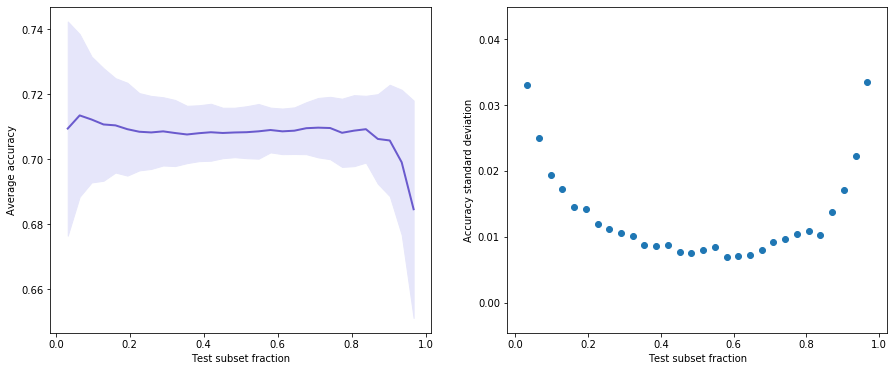


Index of point where accuracy has the smallest standard deviation: 17

Test subset fraction where accuracy has smallest standard deviation: 0.5806
Average accuracy at test fraction with the smallest standard deviation: 0.7091


In [5]:
show_averages_and_variations(test_sizes, averages, standard_deviations, 
                             x_name="Test subset fraction", metric_name="accuracy")

### Conclusions in the case of the "winequality.csv" dataset:

* In this case, the average accuracy shows very similar values for almost the whole range.
* The standard deviation also has a very similar shape as in the previous datasets, it increases for extreme values, and it's lower for intermediate values.
* The test fraction around 0,58 is the one that has the lowest standard deviation and it has the same average accuracy than the rest of the values in the plateau. Therefore, we will **assign 58% of points of the sample to the validations** set. 

## Model comparison (SVC with rbf kernel)

0:00:00.394324 (hh:mm:ss.ss) for 1 iteration/s. 
There are 1499 iterations left. 
Estimated total running time: 0:06:34.324000 (hh:mm:ss.ss)
Real total running time: 0:04:51.522510 (hh:mm:ss.ss)

Index of point where accuracy has the smallest standard deviation: 18

Test fraction where accuracy has smallest standard deviation: 0.6129
Average accuracy at test fraction with the smallest standard deviation: 0.7486


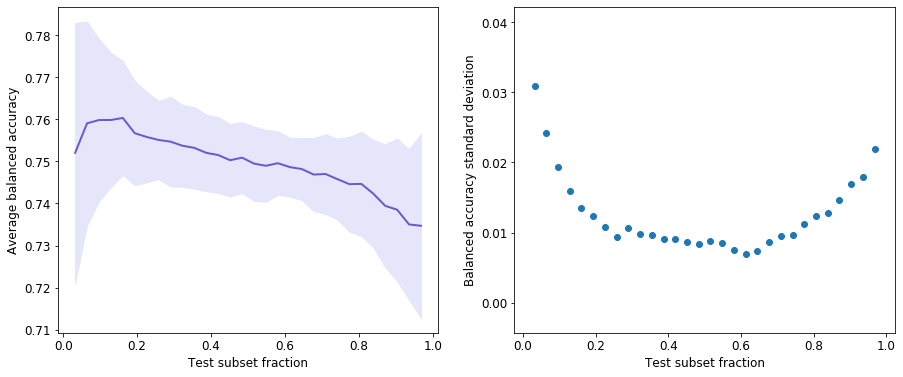


Index of point where balanced accuracy has the smallest standard deviation: 18

Test subset fraction where balanced accuracy has smallest standard deviation: 0.6129
Average balanced accuracy at test fraction with the smallest standard deviation: 0.7486


In [6]:
# Define classifier and scaler
# We will use the same "support vector classification model" from scikit-learn, but with a "rbf" kernel.

classifier = SVC(kernel="rbf", decision_function_shape="ovo", class_weight="balanced")
scaler = StandardScaler()

metric = "accuracy"
num_test_fractions = 30
random_tries = 50
test_sizes, averages, standard_deviations = explore_test_split_ratio(dataset, classifier, scaler=scaler, 
                                metric=metric, num_test_fractions=num_test_fractions, random_tries=random_tries)
show_averages_and_variations(test_sizes, averages, standard_deviations, 
                             x_name="Test subset fraction", metric_name="balanced accuracy")

## Other metrics

In [7]:
# Define classifier and scaler
# We will use "support vector classification model" from scikit-learn, with a "linear" kernel.

classifier = SVC(kernel="linear", decision_function_shape="ovo", class_weight="balanced")
scaler = StandardScaler()

### Balanced accuracy

0:00:00.641736 (hh:mm:ss.ss) for 1 iteration/s. 
There are 199 iterations left. 
Estimated total running time: 0:01:25.564800 (hh:mm:ss.ss)
Real total running time: 0:00:55.651167 (hh:mm:ss.ss)

Index of point where balanced_accuracy has the smallest standard deviation: 18

Test fraction where balanced_accuracy has smallest standard deviation: 0.9048
Average balanced_accuracy at test fraction with the smallest standard deviation: 0.7237


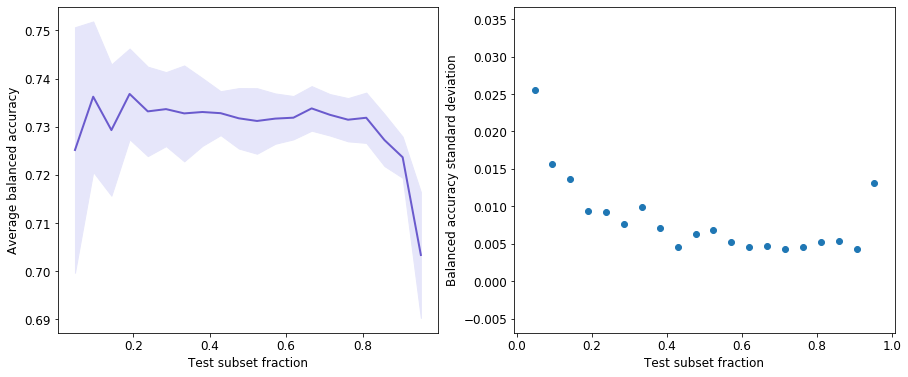


Index of point where balanced accuracy has the smallest standard deviation: 18

Test subset fraction where balanced accuracy has smallest standard deviation: 0.9048
Average balanced accuracy at test fraction with the smallest standard deviation: 0.7237


In [8]:
metric = "balanced_accuracy"
num_test_fractions = 20
random_tries = 10
test_sizes, averages, standard_deviations = explore_test_split_ratio(dataset, classifier, scaler=scaler, 
                                metric=metric, num_test_fractions=num_test_fractions, random_tries=random_tries)
show_averages_and_variations(test_sizes, averages, standard_deviations, 
                             x_name="Test subset fraction", metric_name="balanced accuracy")

### Average precision

0:00:00.567636 (hh:mm:ss.ss) for 1 iteration/s. 
There are 199 iterations left. 
Estimated total running time: 0:01:15.684800 (hh:mm:ss.ss)
Real total running time: 0:00:47.376589 (hh:mm:ss.ss)

Index of point where average_precision has the smallest standard deviation: 14

Test fraction where average_precision has smallest standard deviation: 0.7143
Average average_precision at test fraction with the smallest standard deviation: 0.3670


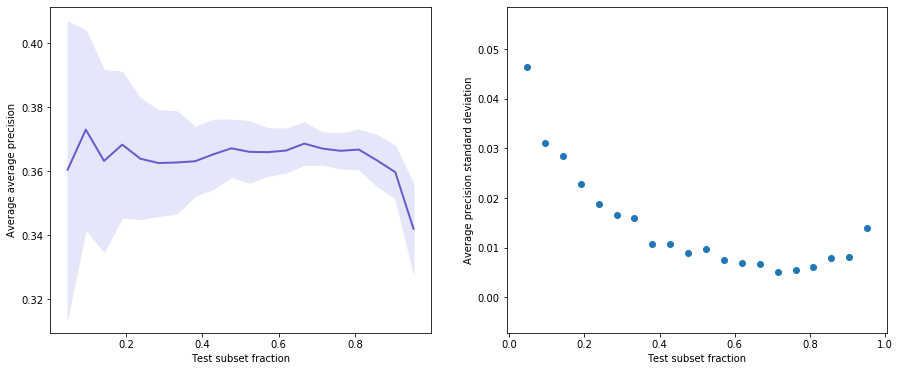


Index of point where average precision has the smallest standard deviation: 14

Test subset fraction where average precision has smallest standard deviation: 0.7143
Average average precision at test fraction with the smallest standard deviation: 0.3670


In [9]:
metric = "average_precision"
num_test_fractions = 20
random_tries = 10
test_sizes, averages, standard_deviations = explore_test_split_ratio(dataset, classifier, scaler=scaler, 
                                metric=metric, num_test_fractions=num_test_fractions, random_tries=random_tries)
show_averages_and_variations(test_sizes, averages, standard_deviations, 
                             x_name="Test subset fraction", metric_name="average precision")

### F1

0:00:00.716528 (hh:mm:ss.ss) for 1 iteration/s. 
There are 199 iterations left. 
Estimated total running time: 0:01:35.537067 (hh:mm:ss.ss)
Real total running time: 0:00:54.730748 (hh:mm:ss.ss)

Index of point where f1 has the smallest standard deviation: 14

Test fraction where f1 has smallest standard deviation: 0.7143
Average f1 at test fraction with the smallest standard deviation: 0.5366


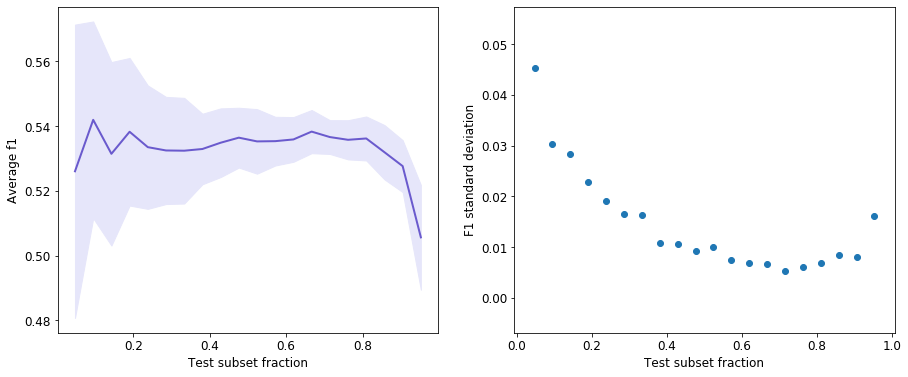


Index of point where f1 has the smallest standard deviation: 14

Test subset fraction where f1 has smallest standard deviation: 0.7143
Average f1 at test fraction with the smallest standard deviation: 0.5366


In [8]:
metric = "f1"
num_test_fractions = 20
random_tries = 10
test_sizes, averages, standard_deviations = explore_test_split_ratio(dataset, classifier, scaler=scaler, 
                                metric=metric, num_test_fractions=num_test_fractions, random_tries=random_tries)
show_averages_and_variations(test_sizes, averages, standard_deviations, 
                             x_name="Test subset fraction", metric_name="f1")

### Precision

0:00:00.700317 (hh:mm:ss.ss) for 1 iteration/s. 
There are 199 iterations left. 
Estimated total running time: 0:01:33.375600 (hh:mm:ss.ss)
Real total running time: 0:00:55.087749 (hh:mm:ss.ss)

Index of point where precision has the smallest standard deviation: 14

Test fraction where precision has smallest standard deviation: 0.7143
Average precision at test fraction with the smallest standard deviation: 0.4114


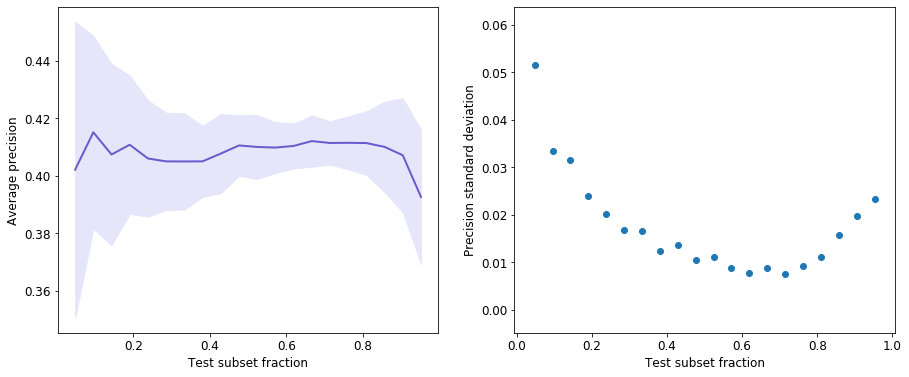


Index of point where precision has the smallest standard deviation: 14

Test subset fraction where precision has smallest standard deviation: 0.7143
Average precision at test fraction with the smallest standard deviation: 0.4114


In [9]:
metric = "precision"
num_test_fractions = 20
random_tries = 10
test_sizes, averages, standard_deviations = explore_test_split_ratio(dataset, classifier, scaler=scaler, 
                                metric=metric, num_test_fractions=num_test_fractions, random_tries=random_tries)
show_averages_and_variations(test_sizes, averages, standard_deviations, 
                             x_name="Test subset fraction", metric_name="precision")

### Recall

0:00:00.684041 (hh:mm:ss.ss) for 1 iteration/s. 
There are 199 iterations left. 
Estimated total running time: 0:01:31.205467 (hh:mm:ss.ss)
Real total running time: 0:00:54.504630 (hh:mm:ss.ss)

Index of point where recall has the smallest standard deviation: 12

Test fraction where recall has smallest standard deviation: 0.6190
Average recall at test fraction with the smallest standard deviation: 0.7723


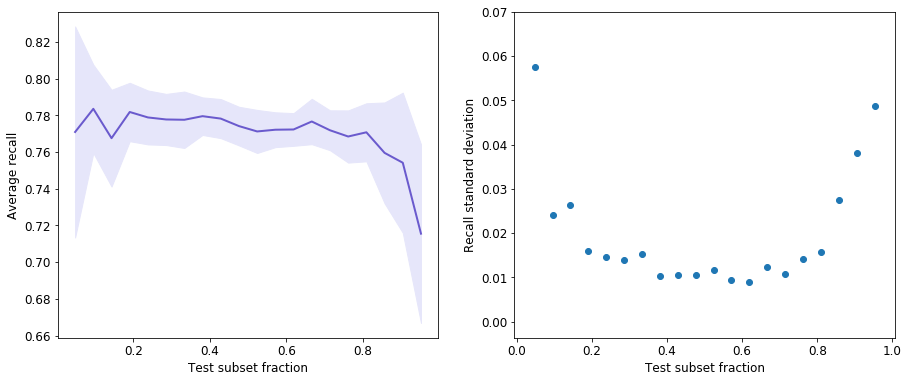


Index of point where recall has the smallest standard deviation: 12

Test subset fraction where recall has smallest standard deviation: 0.6190
Average recall at test fraction with the smallest standard deviation: 0.7723


In [10]:
metric = "recall"
num_test_fractions = 20
random_tries = 10
test_sizes, averages, standard_deviations = explore_test_split_ratio(dataset, classifier, scaler=scaler, 
                                metric=metric, num_test_fractions=num_test_fractions, random_tries=random_tries)
show_averages_and_variations(test_sizes, averages, standard_deviations, 
                             x_name="Test subset fraction", metric_name="recall")

### True positives

0:00:00.657117 (hh:mm:ss.ss) for 1 iteration/s. 
There are 199 iterations left. 
Estimated total running time: 0:01:27.615600 (hh:mm:ss.ss)
Real total running time: 0:00:53.262650 (hh:mm:ss.ss)

Index of point where true_positives has the smallest standard deviation: 0

Test fraction where true_positives has smallest standard deviation: 0.0476
Average true_positives at test fraction with the smallest standard deviation: 39.4000


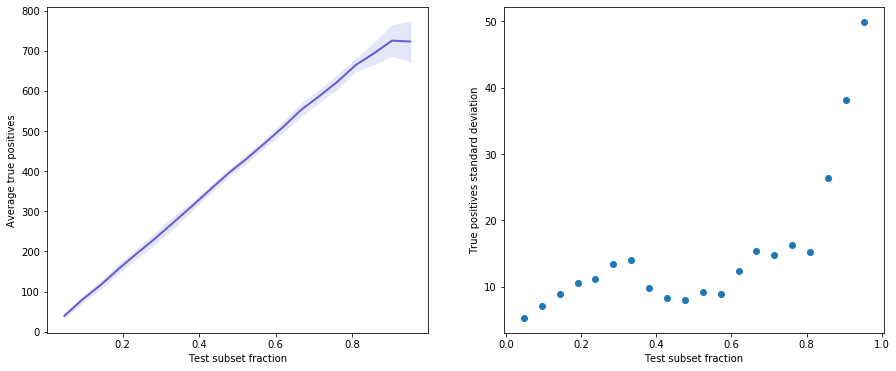


Index of point where true positives has the smallest standard deviation: 0

Test subset fraction where true positives has smallest standard deviation: 0.0476
Average true positives at test fraction with the smallest standard deviation: 39.4000


In [11]:
metric = "true_positives"
num_test_fractions = 20
random_tries = 10
test_sizes, averages, standard_deviations = explore_test_split_ratio(dataset, classifier, scaler=scaler, 
                                metric=metric, num_test_fractions=num_test_fractions, random_tries=random_tries)
show_averages_and_variations(test_sizes, averages, standard_deviations, 
                             x_name="Test subset fraction", metric_name="true positives")

### True positives fraction

0:00:00.644279 (hh:mm:ss.ss) for 1 iteration/s. 
There are 199 iterations left. 
Estimated total running time: 0:01:25.903867 (hh:mm:ss.ss)
Real total running time: 0:00:52.684223 (hh:mm:ss.ss)

Index of point where true_positives_fraction has the smallest standard deviation: 11

Test fraction where true_positives_fraction has smallest standard deviation: 0.5714
Average true_positives_fraction at test fraction with the smallest standard deviation: 0.1677


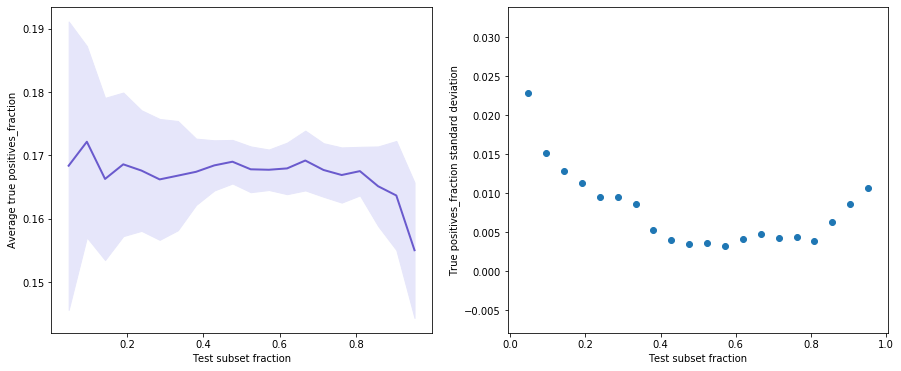


Index of point where true positives_fraction has the smallest standard deviation: 11

Test subset fraction where true positives_fraction has smallest standard deviation: 0.5714
Average true positives_fraction at test fraction with the smallest standard deviation: 0.1677


In [15]:
metric = "true_positives_fraction"
num_test_fractions = 20
random_tries = 10
test_sizes, averages, standard_deviations = explore_test_split_ratio(dataset, classifier, scaler=scaler, 
                                metric=metric, num_test_fractions=num_test_fractions, random_tries=random_tries)
show_averages_and_variations(test_sizes, averages, standard_deviations, 
                             x_name="Test subset fraction", metric_name="true positives fraction")

### False positives

0:00:00.553565 (hh:mm:ss.ss) for 1 iteration/s. 
There are 199 iterations left. 
Estimated total running time: 0:01:13.808667 (hh:mm:ss.ss)
Real total running time: 0:00:46.603909 (hh:mm:ss.ss)

Index of point where false_positives has the smallest standard deviation: 0

Test fraction where false_positives has smallest standard deviation: 0.0476
Average false_positives at test fraction with the smallest standard deviation: 58.7000


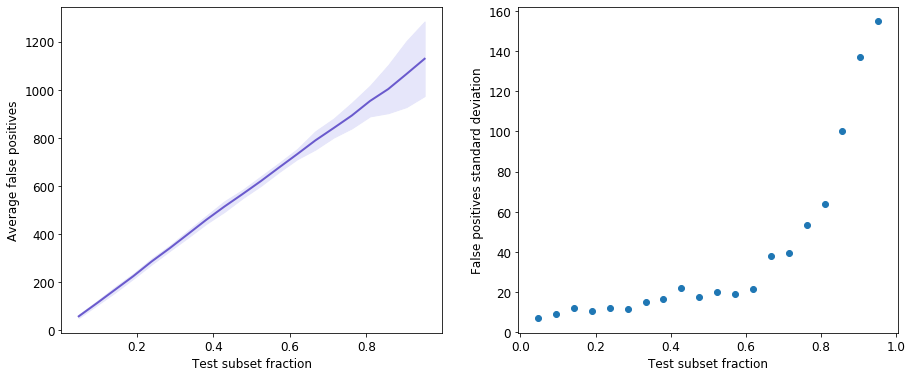


Index of point where false positives has the smallest standard deviation: 0

Test subset fraction where false positives has smallest standard deviation: 0.0476
Average false positives at test fraction with the smallest standard deviation: 58.7000


In [12]:
metric = "false_positives"
num_test_fractions = 20
random_tries = 10
test_sizes, averages, standard_deviations = explore_test_split_ratio(dataset, classifier, scaler=scaler, 
                                metric=metric, num_test_fractions=num_test_fractions, random_tries=random_tries)
show_averages_and_variations(test_sizes, averages, standard_deviations, 
                             x_name="Test subset fraction", metric_name="false positives")

### False positives fraction

0:00:00.630365 (hh:mm:ss.ss) for 1 iteration/s. 
There are 199 iterations left. 
Estimated total running time: 0:01:24.048667 (hh:mm:ss.ss)
Real total running time: 0:00:52.952878 (hh:mm:ss.ss)

Index of point where false_positives_fraction has the smallest standard deviation: 11

Test fraction where false_positives_fraction has smallest standard deviation: 0.5714
Average false_positives_fraction at test fraction with the smallest standard deviation: 0.2417


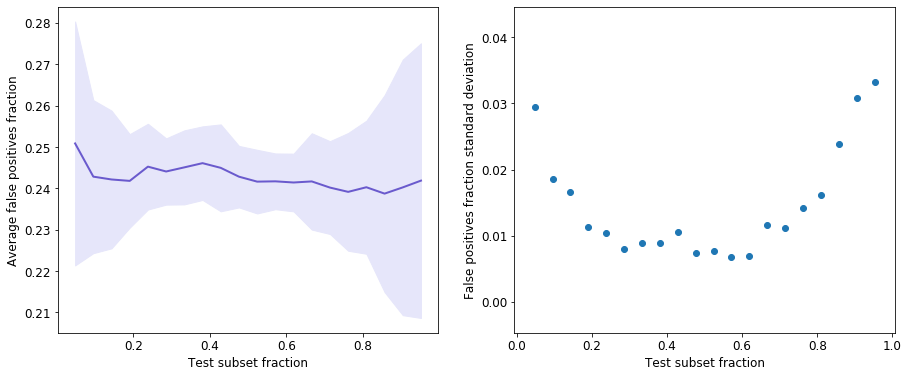


Index of point where false positives fraction has the smallest standard deviation: 11

Test subset fraction where false positives fraction has smallest standard deviation: 0.5714
Average false positives fraction at test fraction with the smallest standard deviation: 0.2417


In [16]:
metric = "false_positives_fraction"
num_test_fractions = 20
random_tries = 10
test_sizes, averages, standard_deviations = explore_test_split_ratio(dataset, classifier, scaler=scaler, 
                                metric=metric, num_test_fractions=num_test_fractions, random_tries=random_tries)
show_averages_and_variations(test_sizes, averages, standard_deviations, 
                             x_name="Test subset fraction", metric_name="false positives fraction")

### True negatives

0:00:00.556051 (hh:mm:ss.ss) for 1 iteration/s. 
There are 199 iterations left. 
Estimated total running time: 0:01:14.140133 (hh:mm:ss.ss)
Real total running time: 0:00:47.290892 (hh:mm:ss.ss)

Index of point where true_negatives has the smallest standard deviation: 0

Test fraction where true_negatives has smallest standard deviation: 0.0476
Average true_negatives at test fraction with the smallest standard deviation: 124.1000


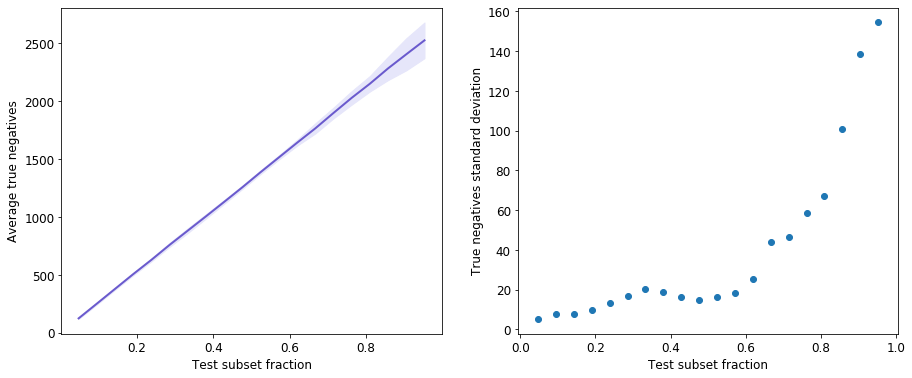


Index of point where true negatives has the smallest standard deviation: 0

Test subset fraction where true negatives has smallest standard deviation: 0.0476
Average true negatives at test fraction with the smallest standard deviation: 124.1000


In [13]:
metric = "true_negatives"
num_test_fractions = 20
random_tries = 10
test_sizes, averages, standard_deviations = explore_test_split_ratio(dataset, classifier, scaler=scaler, 
                                metric=metric, num_test_fractions=num_test_fractions, random_tries=random_tries)
show_averages_and_variations(test_sizes, averages, standard_deviations, 
                             x_name="Test subset fraction", metric_name="true negatives")

### True negatives fraction

0:00:00.633797 (hh:mm:ss.ss) for 1 iteration/s. 
There are 199 iterations left. 
Estimated total running time: 0:01:24.506267 (hh:mm:ss.ss)
Real total running time: 0:00:53.585833 (hh:mm:ss.ss)

Index of point where true_negatives_fraction has the smallest standard deviation: 10

Test fraction where true_negatives_fraction has smallest standard deviation: 0.5238
Average true_negatives_fraction at test fraction with the smallest standard deviation: 0.5408


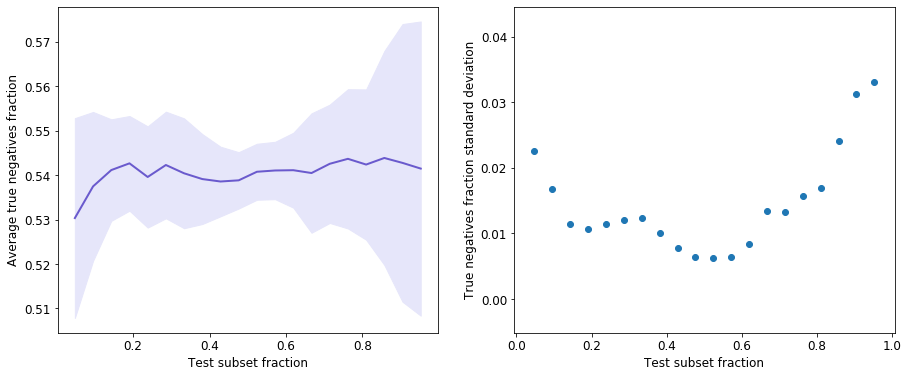


Index of point where true negatives fraction has the smallest standard deviation: 10

Test subset fraction where true negatives fraction has smallest standard deviation: 0.5238
Average true negatives fraction at test fraction with the smallest standard deviation: 0.5408


In [17]:
metric = "true_negatives_fraction"
num_test_fractions = 20
random_tries = 10
test_sizes, averages, standard_deviations = explore_test_split_ratio(dataset, classifier, scaler=scaler, 
                                metric=metric, num_test_fractions=num_test_fractions, random_tries=random_tries)
show_averages_and_variations(test_sizes, averages, standard_deviations, 
                             x_name="Test subset fraction", metric_name="true negatives fraction")

### False negatives

0:00:00.572206 (hh:mm:ss.ss) for 1 iteration/s. 
There are 199 iterations left. 
Estimated total running time: 0:01:16.294133 (hh:mm:ss.ss)
Real total running time: 0:00:47.560208 (hh:mm:ss.ss)

Index of point where false_negatives has the smallest standard deviation: 1

Test fraction where false_negatives has smallest standard deviation: 0.0952
Average false_negatives at test fraction with the smallest standard deviation: 22.2000


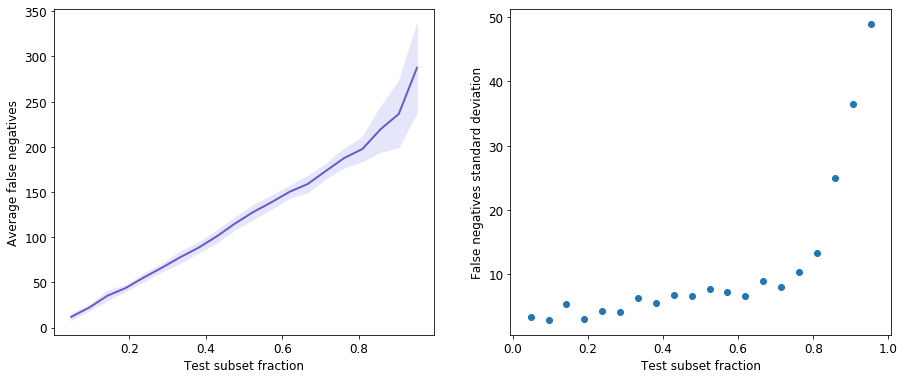


Index of point where false negatives has the smallest standard deviation: 1

Test subset fraction where false negatives has smallest standard deviation: 0.0952
Average false negatives at test fraction with the smallest standard deviation: 22.2000


In [14]:
metric = "false_negatives"
num_test_fractions = 20
random_tries = 10
test_sizes, averages, standard_deviations = explore_test_split_ratio(dataset, classifier, scaler=scaler, 
                                metric=metric, num_test_fractions=num_test_fractions, random_tries=random_tries)
show_averages_and_variations(test_sizes, averages, standard_deviations, 
                             x_name="Test subset fraction", metric_name="false negatives")

### False negatives fraction

0:00:00.601752 (hh:mm:ss.ss) for 1 iteration/s. 
There are 199 iterations left. 
Estimated total running time: 0:01:20.233600 (hh:mm:ss.ss)
Real total running time: 0:00:51.504104 (hh:mm:ss.ss)

Index of point where false_negatives_fraction has the smallest standard deviation: 12

Test fraction where false_negatives_fraction has smallest standard deviation: 0.6190
Average false_negatives_fraction at test fraction with the smallest standard deviation: 0.0495


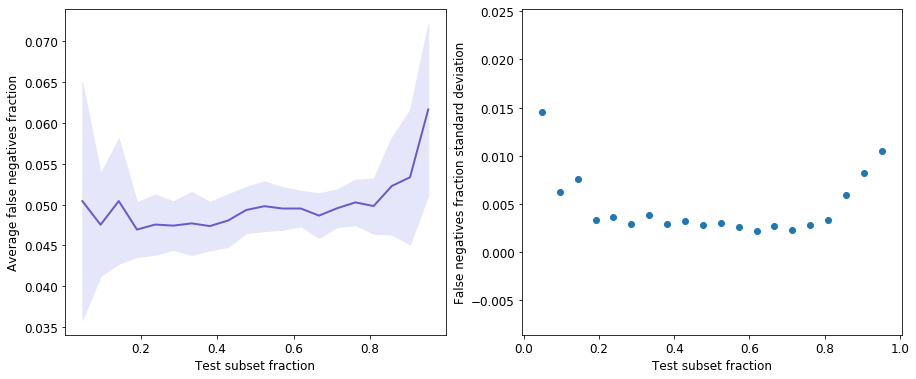


Index of point where false negatives fraction has the smallest standard deviation: 12

Test subset fraction where false negatives fraction has smallest standard deviation: 0.6190
Average false negatives fraction at test fraction with the smallest standard deviation: 0.0495


In [18]:
metric = "false_negatives_fraction"
num_test_fractions = 20
random_tries = 10
test_sizes, averages, standard_deviations = explore_test_split_ratio(dataset, classifier, scaler=scaler, 
                                metric=metric, num_test_fractions=num_test_fractions, random_tries=random_tries)
show_averages_and_variations(test_sizes, averages, standard_deviations, 
                             x_name="Test subset fraction", metric_name="false negatives fraction")

______

# Vehicles dataset (multiclass classification)
This is a dataset describing geometric features of vehicle silhouettes obtained from photos to carry out image recognition and determine the type of vehicle.

## Load file, establish classification model and scaler

In [22]:
# Load file
dataset = pd.read_csv(dataset_files[1])[0:3000]

# Define classifier and scaler
# We will use "support vector classification model" from scikit-learn, with a "linear" kernel.

classifier = SVC(kernel="linear", decision_function_shape="ovo", class_weight="balanced")
scaler = StandardScaler()

## Metrics available for multiclass problems

### Accuracy

0:00:00.019285 (hh:mm:ss.ss) for 1 iteration/s. 
There are 199 iterations left. 
Estimated total running time: 0:00:02.571333 (hh:mm:ss.ss)
Real total running time: 0:00:02.261286 (hh:mm:ss.ss)

Index of point where accuracy has the smallest standard deviation: 10

Test fraction where accuracy has smallest standard deviation: 0.5238
Average accuracy at test fraction with the smallest standard deviation: 0.7842


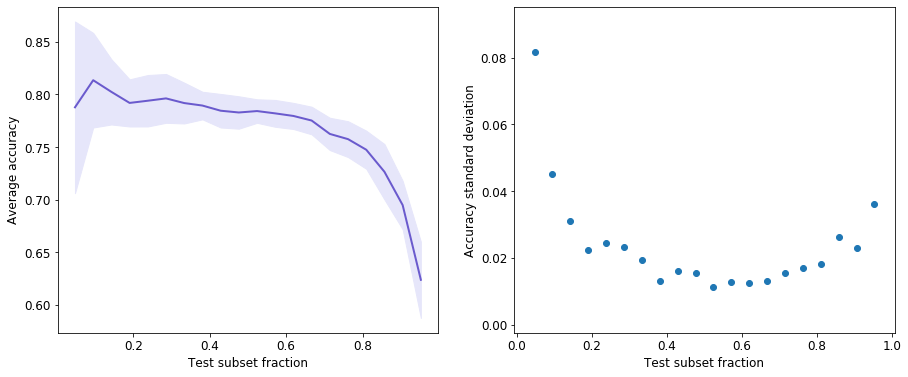


Index of point where accuracy has the smallest standard deviation: 10

Test subset fraction where accuracy has smallest standard deviation: 0.5238
Average accuracy at test fraction with the smallest standard deviation: 0.7842


In [23]:
metric = "accuracy"
num_test_fractions = 20
random_tries = 10
test_sizes, averages, standard_deviations = explore_test_split_ratio(dataset, classifier, scaler=scaler, 
                                metric=metric, num_test_fractions=num_test_fractions, random_tries=random_tries)
show_averages_and_variations(test_sizes, averages, standard_deviations, 
                             x_name="Test subset fraction", metric_name="accuracy")

### Conclusions in the case of the "vehicles.csv" dataset:

* On the left, we have the average score of the trained model with the test dataset as a function of the fraction.
* In this case, we have explored 30 different fractions, and we've used 200 random data subsets for each fraction. 
* Obviously, the model has a better performance as we decrease the test fraction an more data is available for the training, however, it can be clearly seen that around 0.5 this increment is not that notorious and the performance is close to a platteau.
* The greyed area on the left is a representation of the standard deviation of the collection of random trials for each fraction. 
* On the right, a better view of the standard deviation as a function of the test fraction.
* The standard deviation increases rapidly as the test dataset becomes small. But it also increases when it's too big and the training data decreases too much.

  Therefore, we will **assign 40% of points of the sample to the validations** set on the subsequent calculations. There, the score is close to the maximum and the variance of the performance statistics of the model are also close to the minimum. 

### Balanced accuracy

0:00:00.018004 (hh:mm:ss.ss) for 1 iteration/s. 
There are 199 iterations left. 
Estimated total running time: 0:00:02.400533 (hh:mm:ss.ss)
Real total running time: 0:00:02.199014 (hh:mm:ss.ss)

Index of point where balanced_accuracy has the smallest standard deviation: 7

Test fraction where balanced_accuracy has smallest standard deviation: 0.3810
Average balanced_accuracy at test fraction with the smallest standard deviation: 0.7960


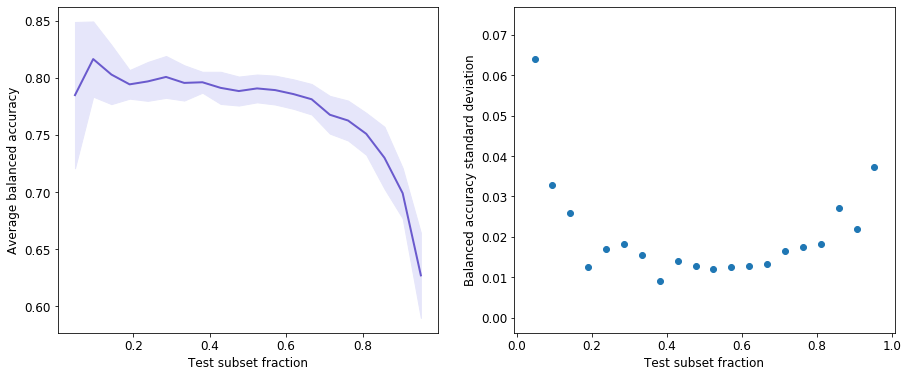


Index of point where balanced accuracy has the smallest standard deviation: 7

Test subset fraction where balanced accuracy has smallest standard deviation: 0.3810
Average balanced accuracy at test fraction with the smallest standard deviation: 0.7960


In [24]:
metric = "balanced_accuracy"
num_test_fractions = 20
random_tries = 10
test_sizes, averages, standard_deviations = explore_test_split_ratio(dataset, classifier, scaler=scaler, 
                                metric=metric, num_test_fractions=num_test_fractions, random_tries=random_tries)
show_averages_and_variations(test_sizes, averages, standard_deviations, 
                             x_name="Test subset fraction", metric_name="balanced accuracy")

----

# Eeg dataset (binary classification)
This is a dataset corresponding to a single continuous electroencephalographic (EEG) measurement (117 seconds) carried out to try to predict when the eyes of the subject are open (0) or closed (1). The headset allowed to measure 14 simultaneous EEG signals. The data is in chronological order.

## Load file, establish classification model and scaler

In [26]:
# Load file
dataset = pd.read_csv(dataset_files[2])[0:3000]

# Define classifier and scaler
# We will use "support vector classification model" from scikit-learn, with a "linear" kernel.

classifier = SVC(kernel="linear", decision_function_shape="ovo", class_weight="balanced")
scaler = StandardScaler()

## Average values of the accuracy and its standard deviations

0:00:00.259519 (hh:mm:ss.ss) for 1 iteration/s. 
There are 199 iterations left. 
Estimated total running time: 0:00:34.602533 (hh:mm:ss.ss)
Real total running time: 0:00:22.040530 (hh:mm:ss.ss)

Index of point where accuracy has the smallest standard deviation: 11

Test fraction where accuracy has smallest standard deviation: 0.5714
Average accuracy at test fraction with the smallest standard deviation: 0.7557


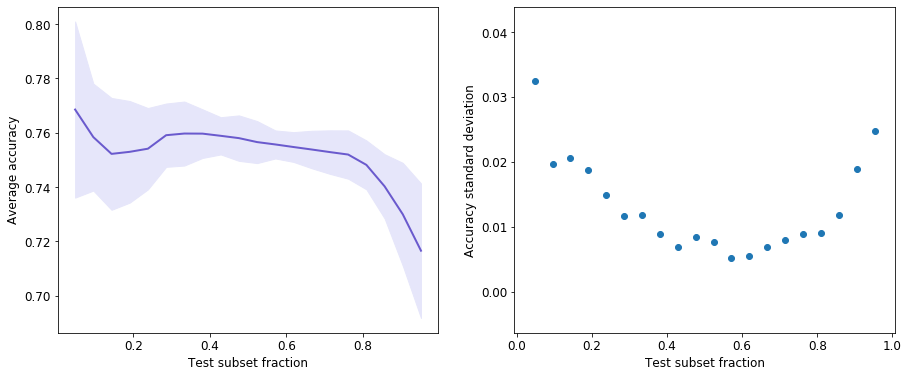


Index of point where accuracy has the smallest standard deviation: 11

Test subset fraction where accuracy has smallest standard deviation: 0.5714
Average accuracy at test fraction with the smallest standard deviation: 0.7557


In [27]:
metric = "accuracy"
num_test_fractions = 20
random_tries = 10
test_sizes, averages, standard_deviations = explore_test_split_ratio(dataset, classifier, scaler=scaler, 
                                metric=metric, num_test_fractions=num_test_fractions, random_tries=random_tries)
show_averages_and_variations(test_sizes, averages, standard_deviations, 
                             x_name="Test subset fraction", metric_name="accuracy")

### Conclusions in the case of the "eeg.csv" dataset:

* The average score also reaches a plateau of sorts as it decreases.
* The standard deviation has a very similar shap as the "vehicles.csv" dataset, it increases for extreme values, and it's lower for intermediate values.
* The test fraction around 0,38 is the one that has the highest average score,  and it's simultanously one of the fractions with the lowest standard deviation. Therefore, we will **assign 38% of points of the sample to the validations** set. 

----

#  Defaults dataset (binary classification)
This is a dataset corresponding to defaults on credit card payments. There is personal information from the clients and their history of past payments. The goal is to predict which clients will fail to pay and default.

## Load file, establish classification model and scaler

In [28]:
# Load file
dataset = pd.read_csv(dataset_files[4])[:3000]
# Readjust "pay" values to range from -1 to 9
dataset.iloc[:,6:12] = dataset.iloc[:,6:12].add(1)

# Define classifier and scaler
# I will use **support vector classification model** from scikit-learn, with a **"linear" kernel**.

classifier = SVC(kernel="linear", decision_function_shape="ovo", class_weight="balanced")
scaler = StandardScaler()

## Average values of the accuracy and its standard deviations

0:00:00.508015 (hh:mm:ss.ss) for 1 iteration/s. 
There are 199 iterations left. 
Estimated total running time: 0:01:07.735333 (hh:mm:ss.ss)
Real total running time: 0:00:42.520203 (hh:mm:ss.ss)

Index of point where accuracy has the smallest standard deviation: 3

Test fraction where accuracy has smallest standard deviation: 0.1905
Average accuracy at test fraction with the smallest standard deviation: 0.7208


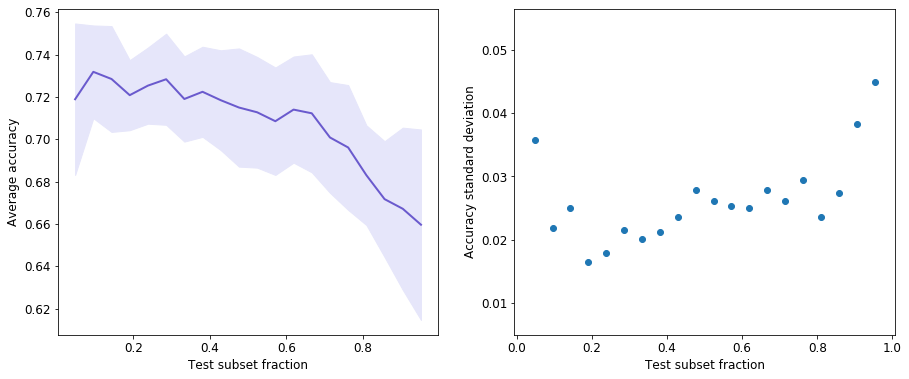


Index of point where accuracy has the smallest standard deviation: 3

Test subset fraction where accuracy has smallest standard deviation: 0.1905
Average accuracy at test fraction with the smallest standard deviation: 0.7208


In [29]:
metric = "accuracy"
num_test_fractions = 20
random_tries = 10
test_sizes, averages, standard_deviations = explore_test_split_ratio(dataset, classifier, scaler=scaler, 
                                metric=metric, num_test_fractions=num_test_fractions, random_tries=random_tries)
show_averages_and_variations(test_sizes, averages, standard_deviations, 
                             x_name="Test subset fraction", metric_name="accuracy")

### Conclusions in the case of the "defaults.csv" dataset:
* We will use a **test data fraction of 36,36%**, because it corresponds to the lowest standard deviation and the average score is one of the highest. 

----